# The Non Random Two Liquids (NRTL) model for *excess Gibbs energy* ($g^E$) and a case study of Liquid-Liquid equilibria of water+ethanol+ethyl acetate

## Fitted parameters
Renon et al. (1969) fitted 1 $\alpha$ valid for all 3 binary interactions $\{(1,2),(1,3),(2,3)\}$ parameter and 6 $A_{i,j}$ parameters, two for each binary interaction filling a non symmetric $A$ matrix.

In [1]:
#unit system constant
R=8.314

# Ethyl acetate (1) + water (2) + ethanol (3)

alpha12 = 0.4

alpha23 = 0.3

alpha13 = 0.3

# 6 binary Aij parameters
Dg12 = 1335 #K
Dg21 = 2510 #K

Dg23 = 976 #K
Dg32 = 88 #K

Dg13 = 301 #K
Dg31 = 322 #K


## Feeding the fitted parameters to the model in matrix structure:
we will assemble the parameters in a matrix structure so that we can access each parameter by its index, as in
`A[0,0]` and `A[0,1]`rather than as `A11` and `A12`, so we can loop trough all of them using an iterator, see below:

In [2]:
import numpy as np
from scipy.constants import R

In [3]:
#assemble matrix with regressed parameters Dg_i,j, according to the model all diagonal terms are zero
Dg = np.array([[0, Dg12, Dg13],
             [Dg21, 0, Dg23],
             [Dg31, Dg32, 0]])


#assemble symmetric matrix alpha
alpha = np.array([[0, alpha12, alpha13],
                [alpha12, 0, alpha23],
                [alpha13, alpha23, 0]])

#finally
A = Dg/R


In [4]:
# chafer's

alpha12=alpha13=alpha23=alpha21=alpha31=alpha23=0.2;


A12=107.99
A21=555.81
A13=1011.98
A31=2277.37
A23=-1113.1
A32=1217.37

alpha = np.array([[0, alpha12, alpha13],
                [alpha12, 0, alpha23],
                [alpha13, alpha23, 0]])

A = np.array([[0, A12, A13],
             [A21, 0, A23],
             [A31, A32, 0]])

In [5]:
from numba import jit
@jit
def Gamma(T,c_x,q_alpha, q_A):
    #note that we used many lines for didatics
    #we can do it in few lines:
    #note that some expression occur more than once below
    #so it may be useful define it as a intermediary recurrent term here
    #and calculate it once to use it then several times
    q_tau     = q_A/T
    q_G       = np.exp(-(q_alpha*q_tau))
    l_D       = ((1/((q_G.T) @ c_x)).T)
    q_E       = (q_tau*q_G) * l_D 
    gamma     = np.exp(((q_E+(q_E.T))-(((q_G * l_D) * (c_x.T)) @ (q_E.T))) @ c_x)
    return gamma

In [6]:
#test it to see that the results are the same
T=293.15
x=np.array([.2,.3,.5]) #normalized
x_as_column = np.array([x]).T
print(Gamma(T,x_as_column,alpha,A)) #test using those trial input

[[ 7.97865398]
 [ 0.31550702]
 [ 0.95773617]]


# Liq-Liq Equilibria Flash
The next step will be using the model in a phase equilibria algorithm, a Liq-Liq equilibria flash calculation

it works as follows:

The degrees of Freedom for a flash calculation are temperature - T, pressure - P and global composition - z


XXX img src from thesis XXX
* ...............  =>guess, xL1 xL2, then calls model(T,P,x)
* ...............//
* .............<=
* T,P,z => algorithm => finds equilibrium xL1 xL2 and BETA

**Equilibriuma criteria**

$$\mu_{i}^{\rm {L1}}=\mu_{i}^{\rm {L2}}, \forall i$$

**Devised algorithm after analytical simplification of repeated contributions:**

$$x_{i}^{\rm {L1}} \gamma_{i}^{\rm {L1}}= x_{i}^{\rm {L2}} \gamma_{i}^{\rm {L2}}, \forall i$$

# algorithm


In [88]:
def ELLflash(Z,beta0,K0,MODEL):
    beta=prevbeta=beta0
    K=prevK=K0
    
    looping2 = 0
    while ( (looping2 == 0) # means do at least once
           or (max(abs(K-prevK))>0.0001 # convergence criteria
               and looping2 < 1000) ): # max number of iterations
        prevbeta = beta
        a = (1/(1+beta*(K-1))) * (K-1)
        beta = beta+(1/((Z.T*a.T) @ a)) @ (Z.T @ a)

        looping3 = 0
        while (abs(beta-prevbeta)>0.0001 # convergence criteria
               and looping3 < 1000): #max number of iterations
            prevbeta = beta
            a=(1/(1+beta*(K-1))) * (K-1)
            beta=beta+(1/((Z.T * a.T) @ a)) @ (Z.T @ a)
            looping3 = looping3 + 1        

        prevK = K
        XI = (1./(1+beta * (K-1))) * Z

        gamaI = MODEL(XI)
        
        XII = K*XI

        gamaII = MODEL(XII)
        
        K = np.exp(np.log(gamaI)-np.log(gamaII))
                       
        looping2 = looping2 + 1    

    #print('Calculation has ended')
    if (looping2 < 1000 and looping3 < 1000):
        converged = 1
#        print('xi',XI)
#        print('xii',XII)
#        print('beta',beta)
    else:
        converged = 0
#        print('unconverged')
    
    return XI, XII, beta, converged

In [89]:
ztest=np.array([[0.3000,
0.4000,
0.3000]]).T

betatest=0.2966

xitest=np.array([[0.0535,
0.5250,
0.4215]]).T


xiitest=np.array([[0.8845,
0.1035,
0.0120]]).T

ktest=1/(xitest/xiitest)

beta0=betatest*1
k0=ktest*1
Z=ztest

print(T)
print(xitest*Gamma(T,xitest,alpha,A))
print(xiitest*Gamma(T,xiitest,alpha,A))

print('hue')
MODEL = lambda x: Gamma(T,x,alpha,A)
ans=ELLflash(Z,beta0,k0,MODEL)
print(ans[0])
print(ans[1])
print(ans[2])
print(ans[3])

293.15
[[ 0.9168827 ]
 [ 0.3519015 ]
 [ 0.17377495]]
[[ 0.91689205]
 [ 0.35194092]
 [ 0.17381633]]
hue
[[ 0.05351624]
 [ 0.52503406]
 [ 0.4214497 ]]
[[ 0.88451339]
 [ 0.10349332]
 [ 0.01199329]]
[[ 0.29661204]]
1


# initial guess


In [90]:
#Estimativas Iniciais

def iguess(Z,MODEL):
    X0 = Z
    gama0 = MODEL(X0)
    
    Xlin = 1/(gama0.T @ Z) * (gama0*Z)

    gamalin = MODEL(Xlin)

    Klin = (1./gamalin) * gama0

    KlinMin = np.min(Klin)
    KlinMax = np.max(Klin)

    nI0 = (KlinMax - Klin) * Z

    XI0 = 1/(np.sum(nI0)) * nI0

    gamaI0=MODEL(XI0)

    nII0=(Klin-KlinMin) * Z

    XII0=1/(np.sum(nII0)) * nII0;

    gamaII0=MODEL(XII0)

    beta0 = 1/(KlinMax-KlinMin) * np.sum(nII0)
    
    K0 = np.exp(np.log(gamaI0)-np.log(gamaII0))

    return beta0, K0

In [91]:
ztest=np.array([[0.3000,
0.4000,
0.3000]]).T
betatest=0.2966
xitest=np.array([[0.0535,
0.5250,
0.4215]]).T
xiitest=np.array([[0.8845,
0.1035,
0.0120]]).T
ktest=1/(xitest/xiitest)

###

Z=ztest

print(T)
print(xitest*Gamma(T,xitest,alpha,A))
print(xiitest*Gamma(T,xiitest,alpha,A))

print('hue')
MODEL = lambda x: Gamma(T,x,alpha,A)

iguesses = iguess(Z,MODEL)

beta0 = iguesses[0]
K0 = iguesses[1]

print(beta0)
print(K0)

ans=ELLflash(Z,beta0,K0,MODEL)
print(ans[0])
print(ans[1])
print(ans[2])
print(ans[3])

293.15
[[ 0.9168827 ]
 [ 0.3519015 ]
 [ 0.17377495]]
[[ 0.91689205]
 [ 0.35194092]
 [ 0.17381633]]
hue
0.394411615605
[[ 35.40198618]
 [  0.21977285]
 [  0.14735411]]
[[ 0.05351532]
 [ 0.52503359]
 [ 0.42145109]]
[[ 0.88450404]
 [ 0.10350028]
 [ 0.01199568]]
[[ 0.29661616]]
1


# grid calc plot

In [210]:
Z1 = np.linspace(0,1,10)
Z2 = np.linspace(0,1,10)
Z3 = np.linspace(0,1,10)

Z1[0]=1e-9
Z2[0]=1e-9
Z3[0]=1e-9

rawZs = np.ndarray((10,10), dtype=object)

flags = np.zeros((10,10))

for i in range(10):
    for j in range(10):
        rawZs[i,j]=np.array([Z1[i],Z2[j],1-Z1[i]-Z2[j]])
        if ( rawZs[i,j][0] + rawZs[i,j][1] +  rawZs[i,j][2] == 1 ):
            flags[i,j] = 1
            
Zs = rawZs[np.where(flags==1)]

npts = Zs.shape[0]
print(npts)

Resultados_beta = np.zeros([npts])
Resultados_conv = np.zeros([npts])
Resultados_Z = np.zeros([3,npts])
Resultados_XI = np.zeros([3,npts])
Resultados_XII = np.zeros([3,npts])

l=0
for k in range(npts):
    MODEL = lambda x: Gamma(T,x,alpha,A)
    beta0, K0 = iguess(np.array([Zs[k]]).T,MODEL)
    #print(beta0,K0)
    #print(Zs[k],beta0,K0)
    ans = ELLflash(np.array([Zs[k]]).T,beta0,K0,MODEL)
    if (0<ans[2] and 1>ans[2]):
        print(ans[0][0][0],ans[0][1][0],ans[0][2][0])
        Resultados_XI[:,l] = np.array([ans[0][0][0],ans[0][1][0],ans[0][2][0]])
        Resultados_XII[:,l] = np.array([ans[1][0][0],ans[1][1][0],ans[1][2][0]])
        Resultados_beta[l] = ans[2]
        Resultados_conv[l] = ans[3]
        print(ans[3])
        l+=1
        
print('done',l)
    


92


/home/segtovichisv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: overflow encountered in true_divide
/home/segtovichisv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in true_divide


1.1301261536e-09 0.0221845118116 0.977815470707
0
1.3495474222e-09 0.0221845061603 0.977815492479
0
1.67470141612e-09 0.0221845059611 0.977815491802
0
4.1482874982e-12 0.793046428093 0.206953572051
0
6.07728694168e-12 0.793046427579 0.206953572092
0
1.13596488886e-11 0.793046429264 0.206953570706
0
8.68456486015e-11 0.793046444755 0.206953555157
0
7.48370007603e-05 1.12524826872e-09 0.999925161874
1
0.00506591101091 0.247727879755 0.747206209234
1
0.157347164107 0.00341097341009 0.839241862482
0
0.0379820202613 0.477942870121 0.484075109603
1
0.0770179575214 0.574827146815 0.348154895604
1
7.4837001084e-05 1.28648715678e-09 0.999925161712
1
0.00130275990163 0.142079783268 0.85661745683
1
0.258414171499 0.00271349247692 0.738872335938
0
0.14397377507 0.00262056814566 0.853405656784
0
0.0554476545947 0.529938099023 0.414614246274
1
0.114258587934 0.624349933556 0.261391478506
1
0.220231727759 0.66823853313 0.111529739111
1
7.48370015161e-05 1.50166323841e-09 0.999925161497
1
0.0018143354

/home/segtovichisv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: overflow encountered in multiply


0.692216008785 0.00297644817135 0.304807543043
0
0.0608074335548 0.0179851299506 0.921207449458
0
0.146874114689 0.649795252937 0.203330632198
1
0.993252014579 9.92684925802e-12 0.00674798541074
1
0.983072096669 0.0116800685755 0.00524783475548
1


/home/segtovichisv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in multiply


0.819852433462 0.00450810280939 0.175639463728
0
0.10358966008 0.612751966094 0.283658373826
1
0.99325201403 1.32593905615e-11 0.00674798595682
1
0.972894277893 0.0216028539095 0.00550286819744
1
0.872647437448 0.114223618613 0.0131289439392
1
0.993252013624 1.99602359347e-11 0.00674798635584
1
0.946904709519 0.0461911236945 0.00690416678668
1
0.993252013983 4.03535272981e-11 0.00674798597689
1


/home/segtovichisv/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in log


done 40


In [211]:
fResultados_XI = Resultados_XI[:,np.where(Resultados_conv==1)]
fResultados_XII = Resultados_XII[:,np.where(Resultados_conv==1)]
fResultados_beta = Resultados_beta[np.where(Resultados_conv==1)]

In [212]:
print(Resultados_XI[:,3]) #ERRADO AQUI

[  4.14828750e-12   7.93046428e-01   2.06953572e-01]


In [213]:
print(fResultados_XI[:,0,3]) #ERRADO AQUI

[ 0.07701796  0.57482715  0.3481549 ]


In [215]:
test_data1 = np.zeros([npts,3])
test_data2 = np.zeros([npts,3])

from matplotlib import pyplot as plt

for k in range(24):
    #print(Resultados_XI[:,0])
    test_data1[k,0:3] = fResultados_XI[:,0,k]
    test_data2[k,0:3] = fResultados_XII[:,0,k]
    #test_data[l,3] = GM[l]

print(test_data1[:,:])
    
a=test_data1[:,0]
b=test_data1[:,1]



[[  7.48370008e-05   1.12524827e-09   9.99925162e-01]
 [  5.06591101e-03   2.47727880e-01   7.47206209e-01]
 [  3.79820203e-02   4.77942870e-01   4.84075110e-01]
 [  7.70179575e-02   5.74827147e-01   3.48154896e-01]
 [  7.48370011e-05   1.28648716e-09   9.99925162e-01]
 [  1.30275990e-03   1.42079783e-01   8.56617457e-01]
 [  5.54476546e-02   5.29938099e-01   4.14614246e-01]
 [  1.14258588e-01   6.24349934e-01   2.61391479e-01]
 [  2.20231728e-01   6.68238533e-01   1.11529739e-01]
 [  7.48370015e-05   1.50166324e-09   9.99925161e-01]
 [  1.81433540e-03   1.64847881e-01   8.33337783e-01]
 [  8.57278213e-02   5.88977067e-01   3.25295112e-01]
 [  1.86217374e-01   6.65388666e-01   1.48393959e-01]
 [  9.93252015e-01   7.93300991e-12   6.74798481e-03]
 [  9.87625510e-01   7.07708078e-03   5.29740927e-03]
 [  1.46874115e-01   6.49795253e-01   2.03330632e-01]
 [  9.93252015e-01   9.92684926e-12   6.74798541e-03]
 [  9.83072097e-01   1.16800686e-02   5.24783476e-03]
 [  1.03589660e-01   6.12751

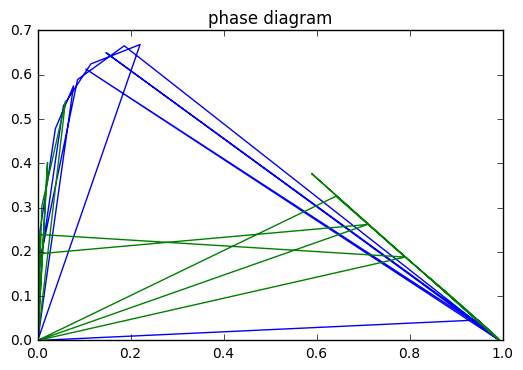

In [216]:

# barycentric coords: (a,b,c)
a=test_data1[:,0]
b=test_data1[:,1]
c=test_data1[:,2]

d=test_data2[:,0]
e=test_data2[:,1]
f=test_data2[:,2]

# create a triangulation out of these points
#Tri = tri.Triangulation(cartx,carty)
#Tri = tri.Triangulation(a,b)

# plot the contour
#plt.tricontourf(cartx,carty,Tri.triangles,v)
#plt.tricontourf(a,b,Tri.triangles,v)


# create the grid
#corners = np.array([[0, 0], [1, 0], [0.5,  np.sqrt(3)*0.5]])
#corners = np.array([[0, 0], [1, 0], [0,1]])
#triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

# creating the grid
#refiner = tri.UniformTriRefiner(triangle)
#trimesh = refiner.refine_triangulation(subdiv=4)

#plotting the mesh
#plt.triplot(trimesh,'k--')

plt.plot(a,b)
plt.plot(d,e)
plt.title('phase diagram')
#plt.axis('off')
plt.show()